# loading essential libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px 

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# setting up the chart size and background
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('fivethirtyeight')

# for Interactive Shells
from IPython.display import display

In [2]:
#loading dataset

df = pd.read_csv('adult.csv')

In [3]:
#lets split data into catagroical and numerical feature so we can undersatnd data insight better


cols_df = pd.DataFrame(df.dtypes)
num_cols = list(cols_df[cols_df[0]=='int64'].index)
cat_cols = list(cols_df[cols_df[0]=='object'].index)
print('Numeric variables includes:','\n',num_cols)
print('\n')
print('Categorical variables includes','\n',cat_cols)

Numeric variables includes: 
 ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']


Categorical variables includes 
 ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'country', 'salary']


## feature engineering

In [4]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
l=LabelEncoder()
o=OrdinalEncoder()

In [5]:
#We use ordinal encoder to Encode Independent features
for i in df.columns:
    if df[i].dtypes=='O' and i!='income':
        df[i]=o.fit_transform(df[i].values.reshape(-1,1))

In [6]:
#We use label encoder to encode label 
df['salary']=l.fit_transform(df['salary'])

In [7]:
from scipy.stats import zscore

In [8]:
def threshold():
    for i in np.arange(3,5,0.2):
        data=df.copy()
        data=data[(z<i).all(axis=1)]
        loss=(df.shape[0]-data.shape[0])/df.shape[0]*100
        print('With threshold {} data loss is {}%'.format(np.round(i,1),np.round(loss,2))) 

In [9]:
z=np.abs(zscore(df))
threshold()

With threshold 3.0 data loss is 15.79%
With threshold 3.2 data loss is 12.17%
With threshold 3.4 data loss is 11.1%
With threshold 3.6 data loss is 10.2%
With threshold 3.8 data loss is 9.0%
With threshold 4.0 data loss is 8.44%
With threshold 4.2 data loss is 7.46%
With threshold 4.4 data loss is 6.08%
With threshold 4.6 data loss is 4.37%
With threshold 4.8 data loss is 1.55%


In [10]:
"""
From above we choose threhold as 4.2 as data is precious and 
we cannot afford to lose more than 8% of data.
"""

'\nFrom above we choose threhold as 4.2 as data is precious and \nwe cannot afford to lose more than 8% of data.\n'

In [11]:
df=df[(z<4.2).all(axis=1)]

**Removing Skewness**

In [12]:
#using Power transformer to remove skewness
from sklearn.preprocessing import PowerTransformer
pt=PowerTransformer()

In [13]:
for i in num_cols:
    if np.abs(df[i].skew())>0.5:
        df[i]=pt.fit_transform(df[i].values.reshape(-1,1))

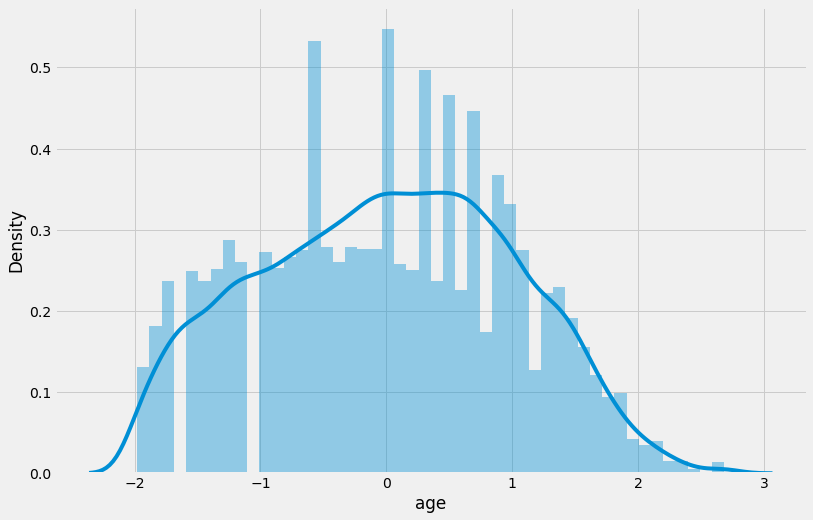

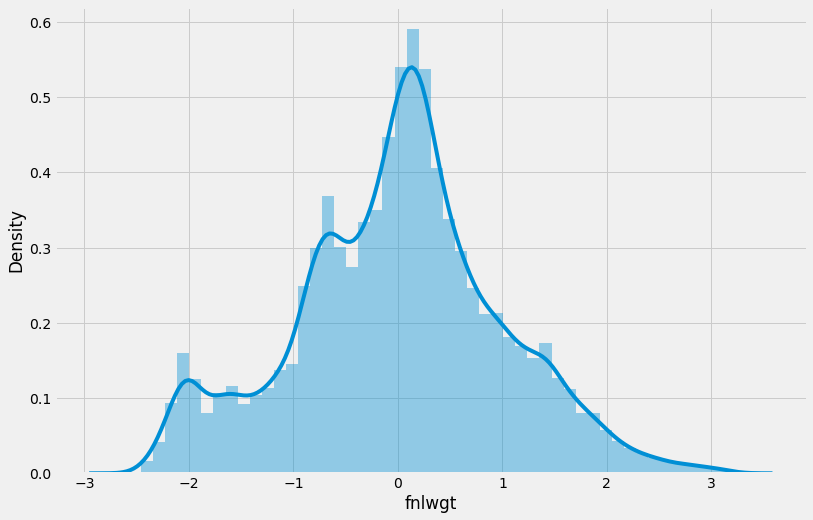

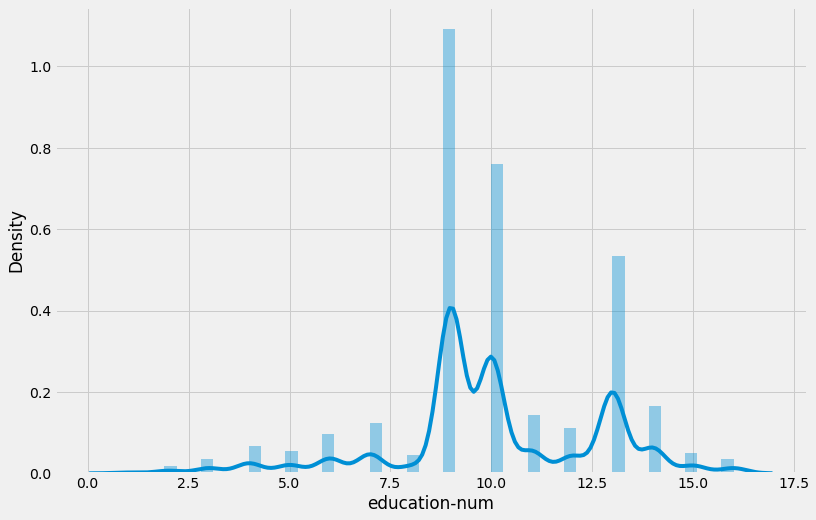

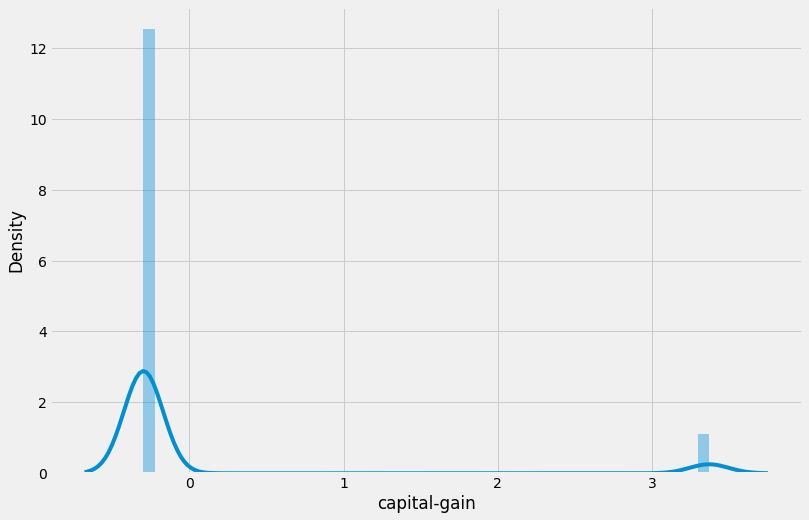

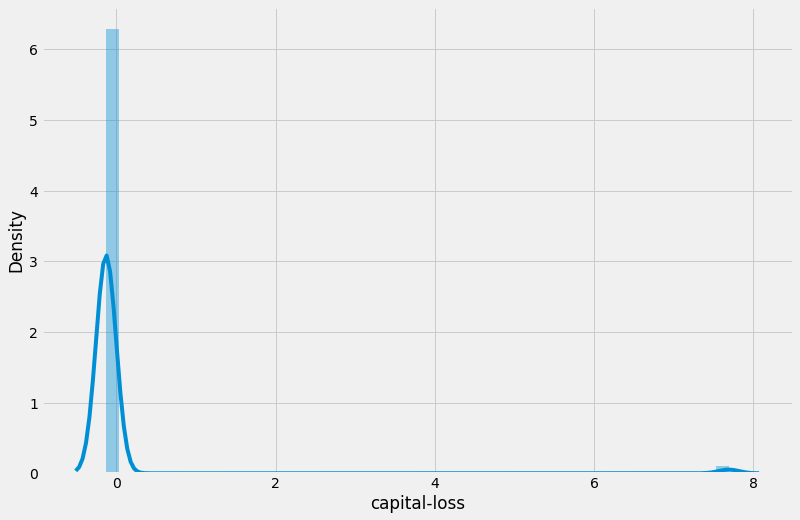

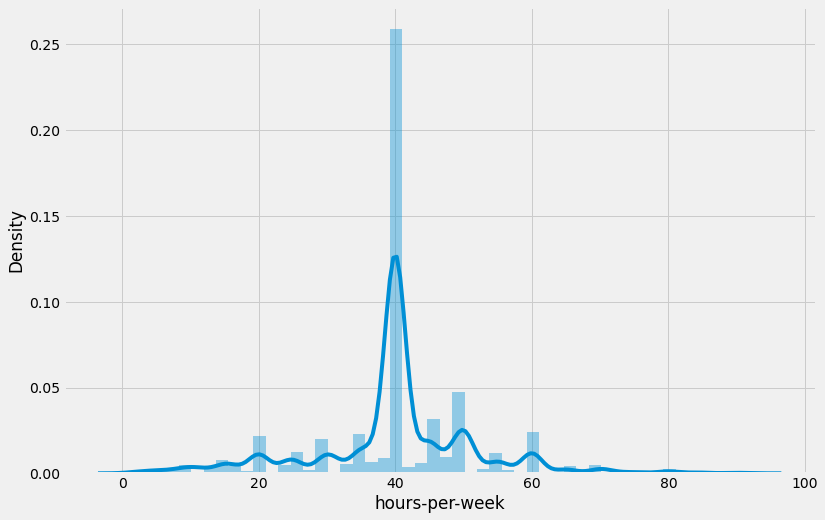

<Figure size 864x576 with 0 Axes>

In [14]:
for i in num_cols:
    sns.distplot(df[i])
    plt.figure()

In [15]:
#A lot of skewness has been resuced but we cannot remove skewness more than this.

In [16]:
#Separating dependent and independent features.
x=df.copy()
x.drop('salary',axis=1,inplace=True)
y=df['salary']

In [17]:
#Oversampling using Smote
from imblearn.over_sampling import SMOTE
over=SMOTE()

In [18]:
x,y=over.fit_resample(x,y)

'\nData is balanced now, both the category of income have 50% data each.\n\n'

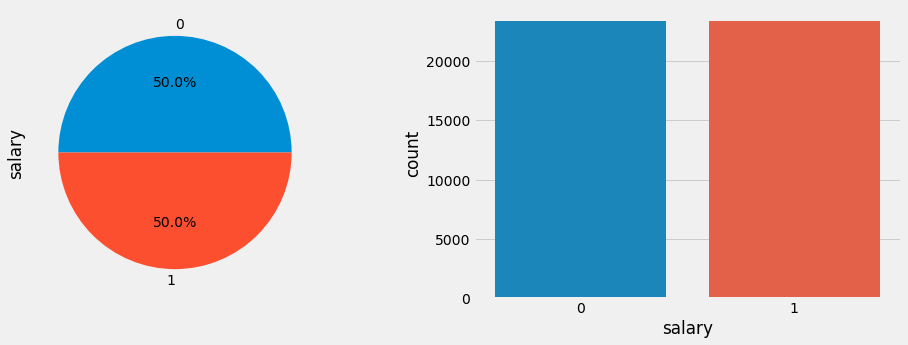

In [19]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
y.value_counts().plot.pie(autopct='%1.1f%%')
plt.subplot(1,2,2)
sns.countplot(y)
y.value_counts()


"""
Data is balanced now, both the category of income have 50% data each.

"""

**scaling the data**

In [20]:
#Scaling the data using min max scaler
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

In [21]:
xd=scaler.fit_transform(x)
x=pd.DataFrame(xd,columns=x.columns)

## model selection

In [22]:
#We import Classification Models
from sklearn.naive_bayes import  GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [23]:
from sklearn.model_selection import train_test_split, cross_val_score

In [24]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_auc_score,roc_curve

In [25]:
#To evaluate performances of all the models
def performance(p,ytest,m,xtest,s):
    print('------------------------------------',m,'------------------------------------')
    print('Accuracy',np.round(accuracy_score(p,ytest),4))
    print('----------------------------------------------------------')
    print('Mean of Cross Validation Score',np.round(s.mean(),4))
    print('----------------------------------------------------------')
    print('AUC_ROC Score',np.round(roc_auc_score(ytest,m.predict_proba(xtest)[:,1]),4))
    print('----------------------------------------------------------')
    print('Confusion Matrix')
    print(confusion_matrix(p,ytest))
    print('----------------------------------------------------------')
    print('Classification Report')
    print(classification_report(p,ytest))

In [26]:
#Creating a list of models which will be created one by one
models=[GaussianNB(),KNeighborsClassifier(),LogisticRegression(),DecisionTreeClassifier(),
        RandomForestClassifier(),GradientBoostingClassifier(),XGBClassifier(verbosity=0)]

In [27]:
#Creates and trains model from the models list
def createmodel(x,y):
    xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.25,random_state=101)
    for i in models:
        model=i
        model.fit(xtrain,ytrain)
        p=model.predict(xtest)
        score=cross_val_score(model,x,y,cv=10)
        performance(p,ytest,model,xtest,score) 

In [91]:
createmodel(x,y)

------------------------------------ GaussianNB() ------------------------------------
Accuracy 0.7834
----------------------------------------------------------
Mean of Cross Validation Score 0.7782
----------------------------------------------------------
AUC_ROC Score 0.8644
----------------------------------------------------------
Confusion Matrix
[[4482 1145]
 [1392 4693]]
----------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.76      0.80      0.78      5627
           1       0.80      0.77      0.79      6085

    accuracy                           0.78     11712
   macro avg       0.78      0.78      0.78     11712
weighted avg       0.78      0.78      0.78     11712

------------------------------------ KNeighborsClassifier() ------------------------------------
Accuracy 0.8501
----------------------------------------------------------
Mean of Cross Validation Score 0.8588

In [92]:
#Random Forest, Gradient Boost, Xtreme Gradient Boost give us the best performance, so we further try hyperparameter tuning on them

In [102]:
#xgb performs better among all model so we will choose it
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [107]:
#hyperparameter tuning for xgboost
import optuna
def objective(trial):
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1),
        'max_depth': trial.suggest_int('max_depth', 2, 9),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-8, 1),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1),
        'colsample_bylevel': trial.suggest_uniform('colsample_bylevel', 0.5, 1),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'objective': 'binary:logistic',
    }
    clf = XGBClassifier(**params)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    return -roc_auc_score(y_test, pred)

In [109]:
#run hyperparameter tuning
study = optuna.create_study()
study.optimize(objective, n_trials=10)

[I 2021-12-10 16:15:00,115] A new study created in memory with name: no-name-8758ef87-8260-4c30-b265-f21be9beab49
[I 2021-12-10 16:15:35,644] Trial 0 finished with value: -0.846894592476489 and parameters: {'learning_rate': 0.00364499193419756, 'max_depth': 5, 'min_child_weight': 2.1999633032959216e-05, 'gamma': 1.0443460025484499e-08, 'subsample': 0.9584297700378123, 'colsample_bytree': 0.8250313088048189, 'colsample_bylevel': 0.7964421042300609, 'reg_alpha': 0.030166705681805968, 'reg_lambda': 0.8848248806945564, 'n_estimators': 448}. Best is trial 0 with value: -0.846894592476489.
[I 2021-12-10 16:16:07,102] Trial 1 finished with value: -0.8788405810308376 and parameters: {'learning_rate': 0.010157055065745142, 'max_depth': 9, 'min_child_weight': 2.8579849184436302e-06, 'gamma': 0.00010411563578862566, 'subsample': 0.6914188324490048, 'colsample_bytree': 0.8890570335515764, 'colsample_bylevel': 0.568468286035552, 'reg_alpha': 0.010878936609592908, 'reg_lambda': 9.408956773441977e-05

In [110]:
#show results
print(study.best_params)
print(study.best_value)

{'learning_rate': 0.03125999577306311, 'max_depth': 9, 'min_child_weight': 5.145059115450818e-06, 'gamma': 0.02810715905283532, 'subsample': 0.8238728569946043, 'colsample_bytree': 0.8049634980552405, 'colsample_bylevel': 0.9449990388848694, 'reg_alpha': 0.022932992629365996, 'reg_lambda': 2.5406456895163724e-06, 'n_estimators': 199}
-0.8993331723408908


In [116]:
#setting fixed seed
import random
import os

SEED = 42

def seed_everything(seed=64):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(SEED)

**finalizing the model**

In [138]:
params = {'learning_rate': 0.03125999577306311, 'max_depth': 9, 'min_child_weight': 5.145059115450818e-06, 
          'gamma': 0.02810715905283532, 'subsample': 0.8238728569946043, 'colsample_bytree': 0.8049634980552405, 
          'colsample_bylevel': 0.9449990388848694, 'reg_alpha': 0.022932992629365996, 'reg_lambda': 2.5406456895163724e-06, 'n_estimators': 199}

In [143]:
def performance1(p,ytest,m,xtest,s):
    print('------------------------------------',m,'------------------------------------')
    print('Accuracy',np.round(accuracy_score(p,ytest),4))
    print('----------------------------------------------------------')
    print('Mean of Cross Validation Score',np.round(s.mean(),4))
    print('----------------------------------------------------------')
    print('AUC_ROC Score',np.round(roc_auc_score(ytest,m.predict_proba(xtest)[:,1]),4))
    print('----------------------------------------------------------')
    print('Confusion Matrix')
    print(confusion_matrix(p,ytest))
    print('----------------------------------------------------------')
    print('Classification Report')
    print(classification_report(p,ytest))

In [144]:
models1=[XGBClassifier(**params, verbosity=0)]

In [145]:
#Creates and trains model from the models list
def createmodel(x,y):
    xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.25,random_state=101)
    for i in models1:
        model=i
        model.fit(xtrain,ytrain)
        p=model.predict(xtest)
        score=cross_val_score(model,x,y,cv=5)
        performance1(p,ytest,model,xtest,score) 

In [146]:
createmodel(x,y)

------------------------------------ XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.9449990388848694, colsample_bynode=1,
              colsample_bytree=0.8049634980552405, gamma=0.02810715905283532,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.03125999577306311, max_delta_step=0, max_depth=9,
              min_child_weight=5.145059115450818e-06, missing=nan,
              monotone_constraints='()', n_estimators=199, n_jobs=2,
              num_parallel_tree=1, random_state=0,
              reg_alpha=0.022932992629365996, reg_lambda=2.5406456895163724e-06,
              scale_pos_weight=1, subsample=0.8238728569946043,
              tree_method='exact', validate_parameters=1, verbosity=0) ------------------------------------
Accuracy 0.901
----------------------------------------------------------
Mean of Cross Validation Score 0.8902
--------------------------------------------------------

**looks like our xgboost model with hyperparameter tuning gives us bit lower performance with respect to default parameters**

In [147]:
#choosing xgboost with deafault parameter as our final model

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=2, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [148]:
predictions = xgb.predict(X_test)

In [153]:
print('------------------------------------------------------------------------')
print('Accuracy',np.round(accuracy_score(y_test, predictions),4))
print('----------------------------------------------------------')
print('AUC_ROC Score',np.round(roc_auc_score(y_test,xgb.predict_proba(X_test)[:,1]),4))
print('----------------------------------------------------------')
print('Confusion Matrix')
print(confusion_matrix(y_test, predictions))
print('----------------------------------------------------------')
print('Classification Report')
print(classification_report(y_test, predictions))

------------------------------------------------------------------------
Accuracy 0.9062
----------------------------------------------------------
AUC_ROC Score 0.9716
----------------------------------------------------------
Confusion Matrix
[[3204  315]
 [ 344 3165]]
----------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      3519
           1       0.91      0.90      0.91      3509

    accuracy                           0.91      7028
   macro avg       0.91      0.91      0.91      7028
weighted avg       0.91      0.91      0.91      7028

